In [1]:
from getdata import preprocessing
from feature_engg import feature_engineering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import ta
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

In [2]:
symbol = 'GC=F'
price_type = 'Close'
df_close = feature_engineering(symbol, price_type)
print(df_close)

                   High          Low         Open        Close  Volume  \
Date                                                                     
2000-08-30   273.899994   273.899994   273.899994   273.899994     0.0   
2000-08-31   278.299988   274.799988   274.799988   278.299988     0.0   
2000-09-01   277.000000   277.000000   277.000000   277.000000     0.0   
2000-09-05   275.799988   275.799988   275.799988   275.799988     2.0   
2000-09-06   274.200012   274.200012   274.200012   274.200012     0.0   
...                 ...          ...          ...          ...     ...   
2022-07-18  1712.400024  1709.199951  1712.199951  1709.199951   264.0   
2022-07-19  1714.400024  1706.099976  1712.300049  1710.000000  1684.0   
2022-07-20  1708.500000  1699.500000  1707.099976  1699.500000   130.0   
2022-07-21  1715.500000  1679.800049  1687.000000  1712.699951   183.0   
2022-07-22  1735.000000  1713.000000  1713.300049  1727.099976   183.0   

             returns       SMA_15    

In [3]:
df_close.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'returns', 'SMA_15', 'SMA_60',
       'MSD_10', 'MSD_30', 'rsi_14'],
      dtype='object')

In [4]:
# splitting the dataset into train val and test set!

split = int(0.70*len(df_close)) # for training

split_test = int(0.9*len(df_close)) 

# train set
X_train = df_close[['SMA_15', 'SMA_60','MSD_10', 'MSD_30', 'rsi_14']].iloc[:split,:]
y_train = df_close[['returns']].iloc[:split,:]
#print(X_train.tail())

# val dataset

X_val = df_close[['SMA_15', 'SMA_60','MSD_10', 'MSD_30', 'rsi_14']].iloc[split:split_test,:]
#print(X_val.tail())
y_val = df_close[['returns']].iloc[split:split_test,:]

# test dataset

X_test = df_close[['SMA_15', 'SMA_60','MSD_10', 'MSD_30', 'rsi_14']].iloc[split_test:,:]
y_test = df_close[['returns']].iloc[split_test:,:]
#print(X_test.head())



In [5]:

# data normalization

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [6]:
# build model

hidden_layers = 5

# Initialize model

regressor = Sequential()

# first layer

regressor.add(Dense(500, input_shape = (X_train_sc.shape[1],), activation = "relu"))

# add hidden layer

for i in range(1, hidden_layers):

    regressor.add(Dense(int(500/i), activation = "relu"))

# output layer

regressor.add(Dense(1, activation = "linear"))

# compile the model

regressor.compile(loss = 'mean_squared_error', metrics='mean_absolute_error', optimizer="adam")

# training

regressor.fit(X_train_sc, y_train, validation_data = (X_test_sc, y_test), epochs = 50)


Epoch 1/50
121/121 [==============================] - 2s 5ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/50
121/121 [==============================] - 1s 4ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/50
121/121 [==============================] - 0s 4ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/50
121/121 [==============================] - 0s 4ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 5/50
121/121 [==============================] - 0s 4ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 6/50
121/121 [==============================] - 0s 4ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 7/50
121/121 [==============================] - 0s 4ms/step - loss: nan - mean_abs

<AxesSubplot:>

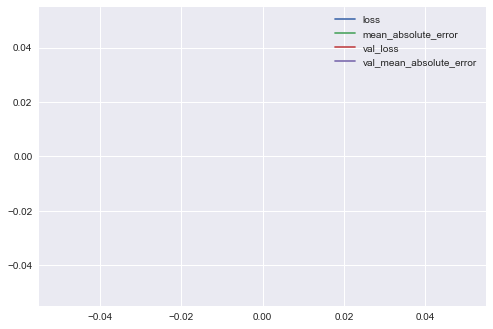

In [7]:
np.log(pd.DataFrame(regressor.history.history)).plot()